# Demo for Faster RCNN

In [1]:
import faster_rcnn.lib
import faster_rcnn.utils

In [2]:
%matplotlib notebook

import os
import sys
import cv2
import copy
import torch
import random
import traceback
import numpy as np
import pandas as pd

from faster_rcnn.lib import nntools as nt
from torch import nn
from faster_rcnn.utils import _utils
from faster_rcnn.lib import rpn
from faster_rcnn.lib import roi_heads
from faster_rcnn.lib import faster_rcnn

from faster_rcnn.lib.rpn import AnchorGenerator
from faster_rcnn.lib.rpn import RPNHead
from faster_rcnn.lib.rpn import RegionProposalNetwork
from faster_rcnn.lib.faster_rcnn import FastRCNNPredictor
from faster_rcnn.lib.faster_rcnn import FasterRCNN
from torchvision.models.detection.image_list import ImageList
from collections import OrderedDict

# from lib import BoundingBox, BoundingBoxes, Evaluator
from faster_rcnn.lib.BoundingBox import *
from faster_rcnn.lib.BoundingBoxes import *
from faster_rcnn.lib.Evaluator import *
from faster_rcnn.utils.utils_box import *

from PIL import Image
import torchvision as tv
import torch.utils.data as td
from matplotlib import patches
from torchsummary import summary
from faster_rcnn.lib import voc_test as voc
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torchvision.ops import boxes as box_ops

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Dataloader

In [4]:
if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

class PascalVOCDataset(voc.VOCDetection):
    """
    """
    
    def __getclasses__(self):
        classes = ('background',
                   'aeroplane',
                   'bicycle',
                   'bird',
                   'boat',
                   'bottle',
                   'bus',
                   'car',
                   'cat',
                   'chair',
                   'cow',
                   'diningtable',
                   'dog',
                   'horse',
                   'motorbike',
                   'person',
                   'pottedplant',
                   'sheep',
                   'sofa',
                   'train',
                   'tvmonitor')

        return classes
    
    def transform_voc(self, img, target, img_size=(800, 800)):
        """
        """
        
        transform = tv.transforms.Compose([
                tv.transforms.Resize(img_size), # Using default interpolation
                tv.transforms.ToTensor(),
                tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        x = transform(img)
        return x, target
    
    def get_lbl_data(self, lbl, yscale=1, xscale=1):
        """
        """

        lbl_arr = np.asarray(self.__getclasses__())
        
        classes = np.zeros((64, 1))
        boxes = np.zeros((64, 4))

        if(type(lbl['annotation']['object']) == dict):
            obj = lbl['annotation']['object']
            bbox = obj['bndbox']
            name = obj['name']
            lbl_class = np.where(lbl_arr == name)[0][0]
            lbl_box = int(bbox['xmin'])//xscale, int(bbox['ymin'])//yscale, int(bbox['xmax'])//xscale, int(bbox['ymax'])//yscale
            classes[0] = lbl_class
            boxes[0] = lbl_box
        else:
            for j, obj in enumerate(lbl['annotation']['object']):
                bbox = obj['bndbox']
                name = obj['name']
                lbl_class = np.where(lbl_arr == name)[0][0]
                lbl_box = int(bbox['xmin'])//xscale, int(bbox['ymin'])//yscale, int(bbox['xmax'])//xscale, int(bbox['ymax'])//yscale
                classes[j] = lbl_class
                boxes[j] = lbl_box

        classes = torch.Tensor(classes).type(torch.float32)
        boxes = torch.Tensor(boxes).type(torch.float32)
        targets = torch.cat((classes, boxes), axis=1)
        return targets
        
    def draw_box(self, image, box, color):
        """Draw 3-pixel width bounding boxes on the given image array.
        color: list of 3 int values for RGB.
        """

        x1, y1, x2, y2 = box
        image[0, y1:y1 + 2, x1:x2] = color[0]
        image[0, y2:y2 + 2, x1:x2] = color[0]
        image[0, y1:y2, x1:x1 + 2] = color[0]
        image[0, y1:y2, x2:x2 + 2] = color[0]

        image[1, y1:y1 + 2, x1:x2] = color[1]
        image[1, y2:y2 + 2, x1:x2] = color[1]
        image[1, y1:y2, x1:x1 + 2] = color[1]
        image[1, y1:y2, x2:x2 + 2] = color[1]

        image[2, y1:y1 + 2, x1:x2] = color[2]
        image[2, y2:y2 + 2, x1:x2] = color[2]
        image[2, y1:y2, x1:x1 + 2] = color[2]
        image[2, y1:y2, x2:x2 + 2] = color[2]
        return image
    
    def plot_boxes(self, image, labels, color, ax=plt):
        """Draw 6-pixel width bounding boxes on the given image array.
        color: list of 3 int values for RGB.
        """
        try:
            image = image.to('cpu')
        except:
            pass
        
        try:
            image = image.numpy()
        except:
            pass
        
        cmap = plt.get_cmap("tab20b")
        colors = [cmap(i) for i in np.linspace(0, 1, 21)]
        colors = random.sample(colors, 21)
    
        for i in labels:
            i = i.type(torch.int64)
            bbox = patches.Rectangle((i[1], i[2]), i[3]-i[1], i[4]-i[2], linewidth=3, alpha=0.7, edgecolor=colors[i[0]-1], facecolor="none")
            ax.add_patch(bbox)
            ax.text(i[1], i[2], self.__getclasses__()[i[0]], color='white', va='top',bbox={"alpha":0.7, "color": colors[i[0]-1], "pad": 0})
        
        ax.axis('off')
        
        return self.myimshow(image, ax)
            
    def plot_frame(self, image, labels, color):
        try:
            image = image.to('cpu')
        except:
            pass
        
        try:
            image = image.numpy()
        except:
            pass
        
        for i in labels:
            i = i.type(torch.int64)
            image = self.draw_box(image, i[1:], color)
            
        return image
    
    def myimshow(self, image, ax=plt):
        """
        """
        
        image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
        image = (image + 1) / 2
        image[image < 0] = 0
        image[image > 1] = 1
        h = ax.imshow(image)
        ax.axis('off')
        return h

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is the image segmentation.
        """
        img = Image.open(self.images[index]).convert('RGB')
        targets = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())

        yscale = img.size[1]/800
        xscale = img.size[0]/800
        
        if self.transforms is not None:
            img, targets = self.transform_voc(img, targets)
        
        targets = self.get_lbl_data(targets, yscale, xscale)
        
        return img, targets

    def number_of_classes(self):
        return len(self.__getclasses__())

In [5]:
voc_det_train = PascalVOCDataset(root='VOC2012', year='2012', transforms = True, image_set='train', download=False)

In [6]:
len(voc_det_train)

5717

In [7]:
voc_det_val = PascalVOCDataset(root='VOC2012', year='2012', transforms = True, image_set='val', download=False)

In [8]:
len(voc_det_val)

5823

In [9]:
voc_det_test = PascalVOCDataset(root='VOC2007', year='2007', transforms=True, image_set='test', download=False)

In [10]:
len(voc_det_test)

4952

# Build NN Model

In [11]:
class NNClassifier(nt.NeuralNetwork):
    
    def __init__(self):
        super(NNClassifier, self).__init__()

In [12]:
tv.__version__

'0.4.2'

In [13]:
class FasterRCNNTransfer(NNClassifier):
    def __init__(self, num_classes=21, score_threshold=0.05, fine_tuning=False):
        super(FasterRCNNTransfer, self).__init__()
        
        model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
        
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        
        backbone = model.backbone
        
        for param in backbone.parameters():
            param.requires_grad = fine_tuning
                        
        anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                           aspect_ratios=((0.5, 1.0, 2.0)))
        
        roi_pooler = tv.ops.MultiScaleRoIAlign(featmap_names=[0],
                                               output_size=7,
                                               sampling_ratio=2)
        rpn_head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
        
        self.fasterrcnn = FasterRCNN(backbone,
                           num_classes=num_classes,
                           rpn_anchor_generator=anchor_generator,
                           rpn_head = rpn_head,
                           box_roi_pool=roi_pooler,
                           box_score_thresh=score_threshold
                           )
        

        
        self.fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    def forward(self, x, d=None):        
        
        targets = None
        if d is not None:
            targets = []
            for i in d:
                last = None
                for j in range(64):
                    if i[j][0] == 0:
                        last = j
                        break
                targets.append((dict({"boxes": i[:last, 1:5], "labels": i[:last, 0].type(torch.int64)})))
    
        features_backbone = self.fasterrcnn.backbone(x)

        features_backbone = features_backbone[0]
        
        if isinstance(features_backbone, torch.Tensor):
            features_backbone = OrderedDict([(0, features_backbone)])
            
        image_list = ImageList(x, [tuple(i.size()[-2:]) for i in x])
        
        proposals_rpn, loss_rpn = self.fasterrcnn.rpn(image_list, features_backbone, targets)
        
        result, loss_roi = self.fasterrcnn.roi_heads(features_backbone, proposals_rpn, [(800, 800)]*16, targets)
                
        y = (result, loss_roi, loss_rpn)
        
        return y

In [14]:
class ClassificationStatsManager(nt.StatsManager):
    
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
    
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.avg_map = 0
    
    def accumulate(self, x, y, d):
        super(ClassificationStatsManager, self).accumulate(x, y, d)
        
        yclasses = []
        yboxes = []
        yscores = []
        for i in y[0]:
            yclasses.append(i['labels'].to('cpu'))
            yboxes.append(i['boxes'].to('cpu'))
            yscores.append(i['scores'].to('cpu'))

        dclasses = []
        dboxes = []
        for i in d:
            last = None
            for j in range(64):
                if i[j][0] == 0:
                    last = j
                    break
            dboxes.append(i[:last, 1:5])
            dclasses.append(i[:last, 0])
            
        bboxes = BoundingBoxes()
        
        for i in range(len(yclasses)):
            for j in range(len(yclasses[i])):
                bboxes.addBoundingBox(BoundingBox(str(i), yclasses[i][j], yboxes[i][j][0], yboxes[i][j][1],
                                                  yboxes[i][j][2], yboxes[i][j][3], typeCoordinates=CoordinatesType.Absolute,
                                                  bbType=BBType.Detected, classConfidence=yscores[i][j], format=BBFormat.XYX2Y2))
            for j in range(len(dclasses[i])):
                bboxes.addBoundingBox(BoundingBox(str(i), dclasses[i][j], dboxes[i][j][0], dboxes[i][j][1],
                                                  dboxes[i][j][2], dboxes[i][j][3], typeCoordinates=CoordinatesType.Absolute,
                                                  bbType=BBType.GroundTruth, format=BBFormat.XYX2Y2))

        eval_class = Evaluator()

        stats = eval_class.GetPascalVOCMetrics(boundingboxes=bboxes, IOUThreshold=0.5, method=MethodAveragePrecision.ElevenPointInterpolation)

        mAp = 0
        acc_ap = 0
        for i in range(len(stats)):
            acc_ap += stats[i]['AP']

        mAp = acc_ap/len(stats)
        
        self.avg_map += mAp
        
    def summarize(self):
        losses = super(ClassificationStatsManager, self).summarize()
        map_precision = 100 * (self.avg_map/self.number_update)
        print(map_precision)
        return {'losses': (losses[0], losses[1], losses[2], losses[3]), 'map_precision': map_precision}

# Create instance of network

In [15]:
net = FasterRCNNTransfer(21, score_threshold=0.5)

# Load Trained Model

In [39]:
checkpoint = torch.load('checkpoint_fasterrcnn/checkpoint.pth.tar')
net.load_state_dict(checkpoint['Net'])

<All keys matched successfully>

# Create Experiment

In [40]:
# Load the experiment file for saved checkpoint

lr = 1e-3
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, voc_det_train, voc_det_test, adam, stats_manager,
                     output_dir="checkpoint_fasterrcnn", perform_validation_during_training=True)

# Plot Statistics

In [22]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[0].clear()
    
    axes[1].clear()
    axes[1].clear()
    
    # We will plot for training and evaluation loss
    # Also, we will subplot losses together
    
    axes[0].plot([(exp1.history[k][0]['losses'][0]+exp1.history[k][0]['losses'][1]) for k in range(exp1.epoch)], label="Training ROI Classification Loss")
    axes[0].plot([(exp1.history[k][1]['losses'][0]+exp1.history[k][1]['losses'][1]) for k in range(exp1.epoch)], label="Training ROI Classification Loss")
 
    axes[1].plot([(exp1.history[k][0]['losses'][2]+exp1.history[k][0]['losses'][3]) for k in range(exp1.epoch)], label="Training RPN Box Regression loss")
    axes[1].plot([(exp1.history[k][1]['losses'][2]+exp1.history[k][1]['losses'][3]) for k in range(exp1.epoch)], label="Training RPN Box Regression loss")
    
    axes[0].set_ylabel('ROI Loss')

    axes[1].set_ylabel('RPN Loss')

    axes[0].set_xlabel('Epoch')
    axes[1].set_xlabel('Epoch')

    axes[0].legend(['Training', 'Validation'])
    axes[1].legend(['Training', 'Validation'])

    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


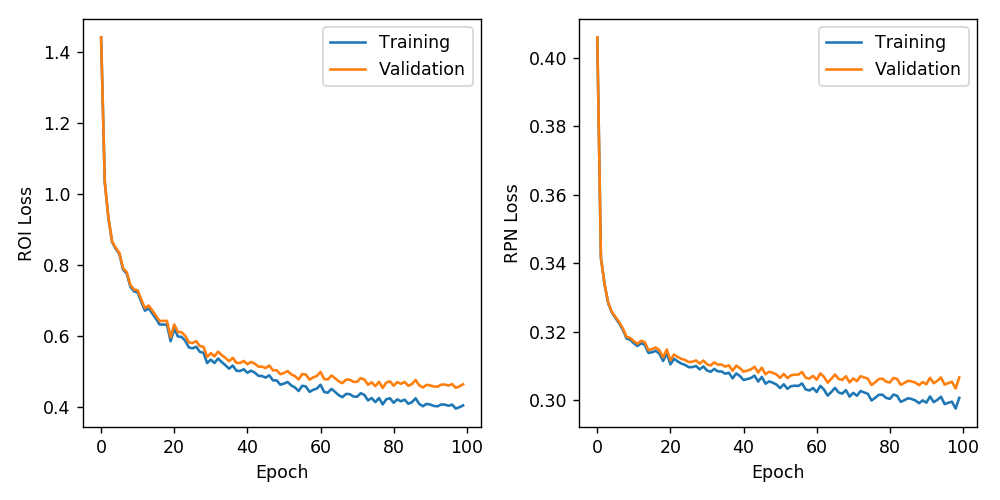

In [42]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
plot(exp1, fig, axes)
plt.savefig('Faster_RCNN_Stats.jpg')

# Perform Detection

<IPython.core.display.Javascript object>


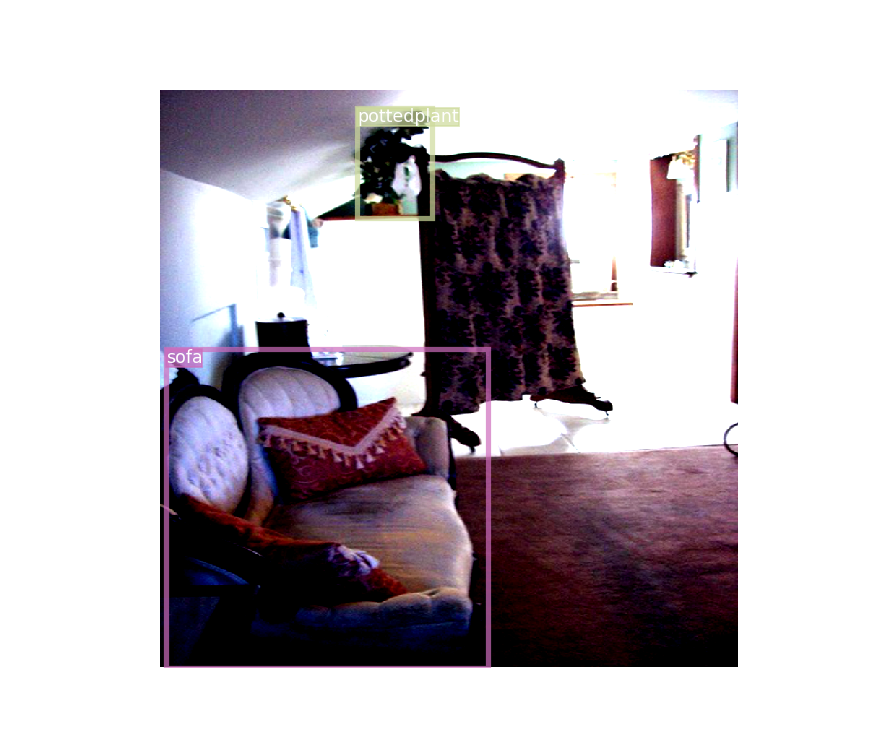

In [21]:
fig, ax = plt.subplots(figsize=(7, 6))
net.eval()
x, lbl = voc_det_test.__getitem__(3224)
temp_last = None
for i in range(lbl.size()[0]):
    if lbl[i][0] == 0:
        temp_last = i
        break;
lbl = lbl[:temp_last]
y = net(x.view(1, 3, 800, 800).to(device))
labels = torch.cat((y[0][0]['labels'].view(y[0][0]['labels'].size()[0], 1), y[0][0]['boxes'].type(torch.int64)), dim=1)
voc_det_test.plot_boxes(x.numpy(), lbl, [1, 0, 0], ax)

plt.savefig('Faster_RCNN_Detection.jpg')

# Test on Video

In [22]:
vidObj = cv2.VideoCapture('Test_Video.mp4')
out = cv2.VideoWriter('./Faster_RCNN_Video.avi', cv2.VideoWriter_fourcc(*"ffds"), 30, (640, 360))
from time import time
count = 0
time1 = time()
while True:
    success, frame = vidObj.read()
    if success == True:
        frame = cv2.resize(frame, (800, 800), interpolation=cv2.INTER_CUBIC) #Read frame and resize
        frame1 = Image.fromarray(frame) # Convert numpy frame to PIL
        x = voc_det_train.transform_voc(frame1, None) # Transform frame as input
        y = net(x[0].view(1, 3, 800, 800).to(device)) # Process through device
        labels = torch.cat((y[0][0]['labels'].view(y[0][0]['labels'].size()[0], 1), y[0][0]['boxes'].type(torch.int64)), dim=1)
        frame = np.moveaxis(frame, [0, 1, 2], [1, 2, 0])
        
        # Plot output labels
        frame = voc_det_train.plot_frame(frame, labels, [0, 0, 255])
        frame = np.moveaxis(frame, [0, 1, 2], [2, 0, 1])

        frame = frame.astype('uint8')
        frame = cv2.resize(frame, dsize=(640, 360), interpolation=cv2.INTER_CUBIC)
        out.write(frame)
        count+=1
        if(count%50 == 0):
            print('FPS ' + str(count/(time() - time1)))
    else:
        break

out.release()
vidObj.release()